In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [3]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [4]:
xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

In [7]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)

f(*minima_)

array([0.])

(-4.5, 4.5)

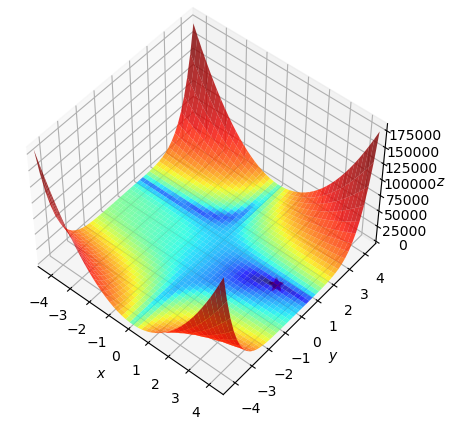

In [8]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

In [9]:
dz_dx = elementwise_grad(f, argnum=0)(x, y)
dz_dy = elementwise_grad(f, argnum=1)(x, y)

(-4.5, 4.5)

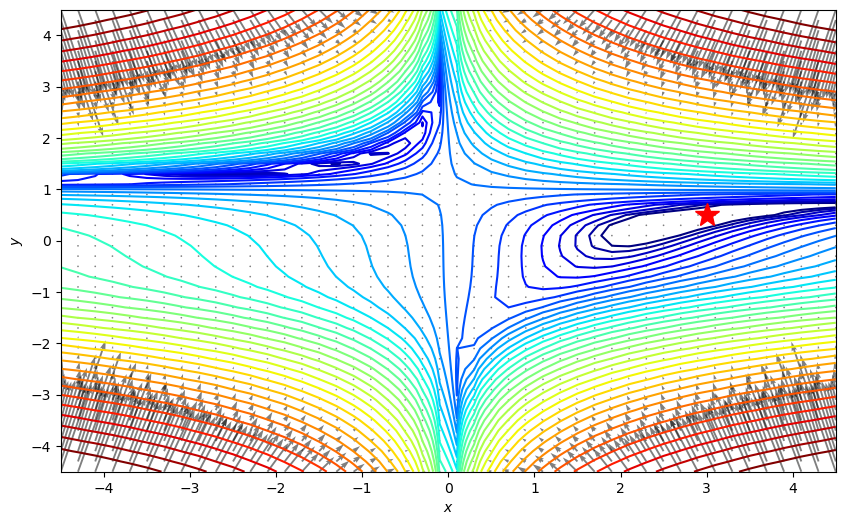

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(x, y, x - dz_dx, y - dz_dy, alpha=.5)
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

In [13]:
x0 = np.array([3., 4.])
func = value_and_grad(lambda args: f(*args))

In [16]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

path_ = [x0]
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=make_minimize_cb(path_))

path = np.array(path_).T

(-4.5, 4.5)

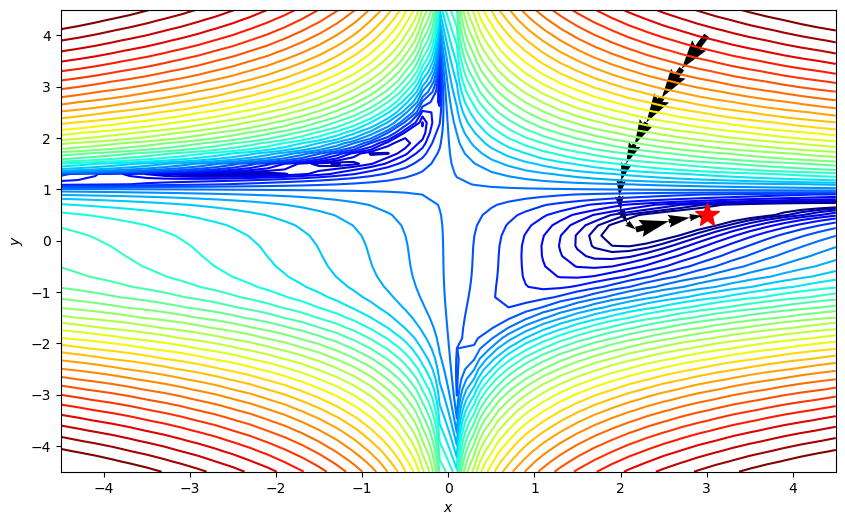

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

(-4.5, 4.5)

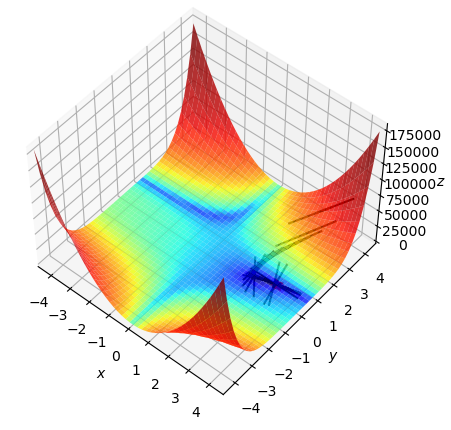

In [18]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], f(*path[::,:-1]), 
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], f(*(path[::,1:]-path[::,:-1])), 
          color='k')
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [2]:
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [3]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points
    
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [7]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

In [23]:
methods = [
    "CG",
#   "BFGS",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
#   "dogleg",
#   "trust-ncg"
]

xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x, y)

minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)

x0 = np.array([3., 4.])
func = value_and_grad(lambda args: f(*args))

minimize_ = partial(minimize, fun=func, x0=x0, jac=True, bounds=[(xmin, xmax), (ymin, ymax)], tol=1e-20)

In [24]:
paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(x0)

In [25]:
results = {method: minimize_(method=method, callback=make_minimize_cb(paths_[method])) for method in methods}

/home/alex/miniconda3/envs/torch23/lib/python3.11/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
/home/alex/miniconda3/envs/torch23/lib/python3.11/site-packages/scipy/optimize/_minimize.py:566: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [26]:
paths = [np.array(paths_[method]).T for method in methods]
zpaths = [f(*path) for path in paths]

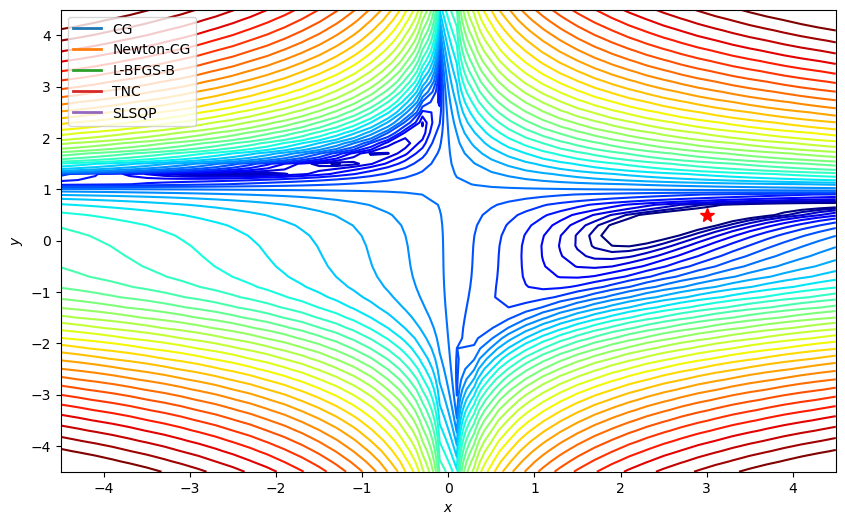

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [39]:
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [95]:
x = np.linspace(-4.5, 4.5, 500)
y = np.linspace(-4.5, 4.5, 500)
x, y = np.meshgrid(x, y)
z = f(x, y)

Text(0.5, 0.92, 'Graphe 3D de la fonction f')

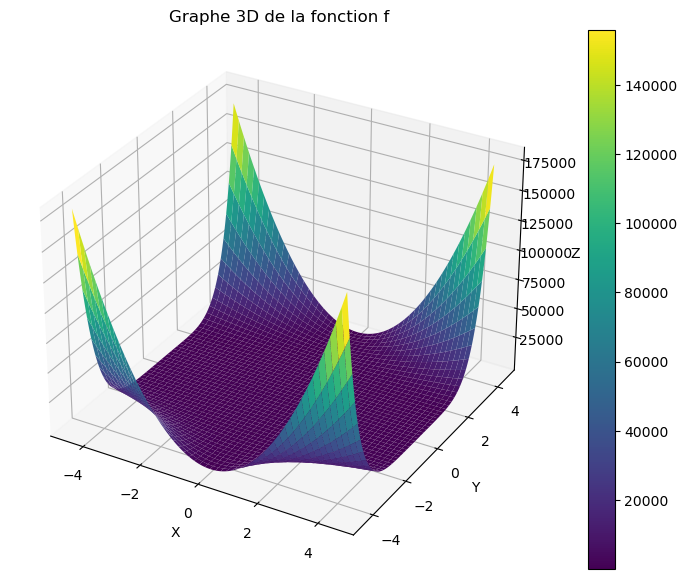

In [43]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, cmap='viridis')

fig.colorbar(surf)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title("Graphe 3D de la fonction f")

In [44]:
import torch

In [358]:
#def f(x, y):
#    return x**2-y**2

gaussian = lambda t, mu, sigma: 1/(sigma * (np.sqrt(2*np.pi))) * torch.exp(-((t - mu) ** 2) / (2 * sigma ** 2))

def f(x, y):
    z = -gaussian(x, 1., 0.2) * gaussian(y, -0.5, 0.2)
    z -= gaussian(x, -1., 0.2) * gaussian(y, 0.5, 0.2)
    z -= gaussian(x, -0.5, 0.2) * gaussian(y, -0.5, 0.2)
    return z

In [359]:
params = torch.tensor([0., 0.], requires_grad=True)

In [360]:
points = []

for i in range(200):
    loss = f(params[0], params[1])
    print(loss.item())

    params.grad = None

    loss.backward()

    points.append((params[0].item(), params[1].item(), loss.item()))
    
    params.data -= 0.01 * params.grad

print(loss.item())
print(params)

-0.007682336959987879
-0.007868754677474499
-0.008063624612987041
-0.008267511613667011
-0.00848102755844593
-0.008704845793545246
-0.008939697407186031
-0.009186385199427605
-0.009445790201425552
-0.009718874469399452
-0.010006709024310112
-0.01031045988202095
-0.010631433688104153
-0.0109710693359375
-0.011330971494317055
-0.011712927371263504
-0.0121189309284091
-0.012551209889352322
-0.013012298382818699
-0.01350503321737051
-0.014032617211341858
-0.014598697423934937
-0.015207442454993725
-0.01586361974477768
-0.016572698950767517
-0.017341015860438347
-0.018175899982452393
-0.019085930660367012
-0.020081160590052605
-0.021173445507884026
-0.02237686887383461
-0.023708289489150047
-0.025187987834215164
-0.02684064768254757
-0.028696449473500252
-0.030792752280831337
-0.03317628800868988
-0.035906124860048294
-0.039057835936546326
-0.042729701846838
-0.047051265835762024
-0.052196428179740906
-0.05840342864394188
-0.06600575894117355
-0.07548247277736664
-0.0875423327088356
-0.1032

In [361]:
points

[(0.0, 0.0, -0.007682336959987879),
 (-0.0009601291967555881, -0.0009601291967555881, -0.007868754677474499),
 (-0.0019416757859289646, -0.0019416699651628733, -0.008063624612987041),
 (-0.0029455595649778843, -0.0029455418698489666, -0.008267511613667011),
 (-0.00397275947034359, -0.003972724080085754, -0.00848102755844593),
 (-0.005024317651987076, -0.005024258513003588, -0.008704845793545246),
 (-0.006101347040385008, -0.0061012571677565575, -0.008939697407186031),
 (-0.007205034606158733, -0.007204907946288586, -0.009186385199427605),
 (-0.00833665207028389, -0.008336481638252735, -0.009445790201425552),
 (-0.009497559629380703, -0.009497338905930519, -0.009718874469399452),
 (-0.01068921759724617, -0.01068893913179636, -0.010006709024310112),
 (-0.011913195252418518, -0.011912851594388485, -0.01031045988202095),
 (-0.013171179220080376, -0.013170763850212097, -0.010631433688104153),
 (-0.014464990235865116, -0.014464495703577995, -0.0109710693359375),
 (-0.015796594321727753, -0.0

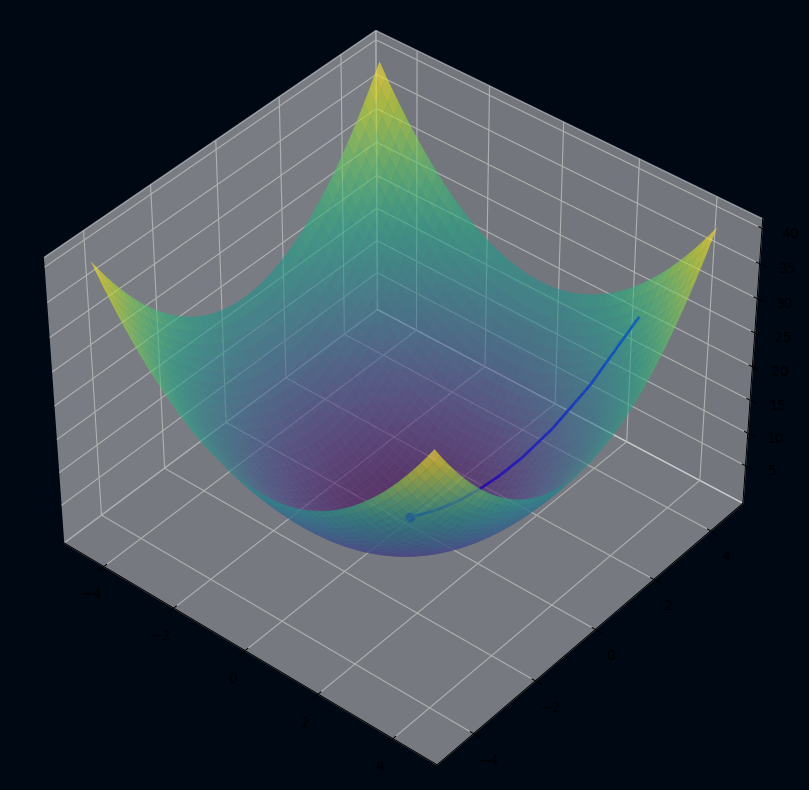

In [271]:
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection='3d', elev=40, azim=-50)

x = np.linspace(-4.5, 4.5, 500)
y = np.linspace(-4.5, 4.5, 500)
x, y = np.meshgrid(x, y)
z = f(x, y)

ax.plot_surface(x, y, z, cmap='viridis', alpha=0.6)
fig.set_facecolor('#000814')
ax.set_facecolor('#000814')

line, = ax.plot([], [], [], 'b', lw=2)
point, = ax.plot([], [], [], 'bo')

line.set_data([], [])
line.set_3d_properties([])
point.set_data([], [])
point.set_3d_properties([])

for i in range(path.shape[1]):
    line.set_data(path[0,:i], path[1,:i])
    line.set_3d_properties(f(*path[::,:i]))
    point.set_data(path[0,i-1:i], path[1,i-1:i])
    point.set_3d_properties(f(*path[::,i-1:i]))

    #plt.savefig('figures/' + str(i) + '.png')